## Introduction
Recommendations are being used to recommend everything from movies to music to friends to new destinations. There are three main methods for implementing recommendations that you will become familiar with throughout this lesson:

- Knowledge Based Recommendations
- Collaborative Filtering Based Recommendations
- Content Based Recommendations

Within Collaborative Filtering, there are two main branches:

- Model Based Collaborative Filtering
- Neighborhood Based Collaborative Filtering

## Similarity Metrics
In order to implement Neighborhood Based Collaborative Filtering, you will learn about some common ways to measure the similarity between two users (or two items) including:

1. Pearson's correlation coefficient
2. Spearman's correlation coefficient
3. Kendall's Tau
4. Euclidean Distance
5. Manhattan Distance

You will learn why sometimes one metric works better than another by looking at a specific situation where one metric provides more information than another.

## Business Cases For Recommendations
Finally, you will look at the four ideas needed for businesses to implement successful recommendations to drive revenue, which include:

1. Relevance
2. Novelty
3. Serendipity
4. Increased Diversity


### Recommendations with MovieTweetings: Getting to Know The Data

Throughout this lesson, you will be working with the [MovieTweetings Data](https://github.com/sidooms/MovieTweetings/tree/master/recsyschallenge2014).  To get started, you can read more about this project and the dataset from the [publication here](http://crowdrec2013.noahlab.com.hk/papers/crowdrec2013_Dooms.pdf).

**Note:** There are solutions to each of the notebooks available by hitting the orange jupyter logo in the top left of this notebook.  Additionally, you can watch me work through the solutions on the screencasts that follow each workbook. 

To get started, read in the libraries and the two datasets you will be using throughout the lesson using the code below.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tests as t

%matplotlib inline

# Read in the datasets
movies = pd.read_csv('https://raw.githubusercontent.com/sidooms/MovieTweetings/master/latest/movies.dat', delimiter='::', header=None, names=['movie_id', 'movie', 'genre'], dtype={'movie_id': object}, engine='python')
reviews = pd.read_csv('https://raw.githubusercontent.com/sidooms/MovieTweetings/master/latest/ratings.dat', delimiter='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'], dtype={'movie_id': object, 'user_id': object, 'timestamp': object}, engine='python')


#### 1. Take a Look At The Data 

Take a look at the data and use your findings to fill in the dictionary below with the correct responses to show your understanding of the data.

In [3]:
movies.head()

,movie_id,movie,genre
0,0000008,Edison Kinetoscopic Record of a Sneeze (1894),Documentary|Short
1,0000010,La sortie des usines Lumière (1895),Documentary|Short
2,0000012,The Arrival of a Train (1896),Documentary|Short
3,25,The Oxford and Cambridge University Boat Race ...,NaN
4,0000091,Le manoir du diable (1896),Short|Horror


In [4]:
reviews.head()

,user_id,movie_id,rating,timestamp
0,1,0114508,8,1381006850
1,2,0358273,9,1579057827
2,2,10039344,5,1578603053
3,2,6751668,9,1578955697
4,2,7131622,8,1579559244


In [5]:
print(movies.movie_id.count())
print(reviews.rating.value_counts().index)


35279
Int64Index([8, 7, 9, 6, 10, 5, 4, 3, 1, 2, 0], dtype='int64')


In [6]:
genre = []
for i in range(movies.shape[0]):
    try:
        genre.extend(movies['genre'].loc[i].split('|'))
    except AttributeError:
        pass

genre_set = set(genre)
len(genre_set)

28

In [7]:
len(reviews.user_id.unique())

66811

In [8]:
reviews.rating.isnull().sum()

0

In [9]:
reviews['rating'].describe()

count    857615.000000
mean          7.315475
std           1.854065
min           0.000000
25%           6.000000
50%           8.000000
75%           9.000000
max          10.000000
Name: rating, dtype: float64

In [10]:
# Use your findings to match each variable to the correct statement in the dictionary


dict_sol1 = {
'The number of movies in the dataset': 35263,
'The number of ratings in the dataset': 11,
'The number of different genres': 28,
'The number of unique users in the dataset': 66722,
'The number missing ratings in the reviews dataset':0,
'The average rating given across all ratings': 7,
'The minimum rating given across all ratings': 0,
'The maximum rating given across all ratings': 10
}

# Originally, I had this to check your solution, but the 
# links are live and updating.  That didn't end up being
# a great idea


#### 2. Data Cleaning

Next, we need to pull some additional relevant information out of the existing columns. 

For each of the datasets, there are a couple of cleaning steps we need to take care of:

#### Movies
* Pull the date from the title and create new column
* Dummy the date column with 1's and 0's for each century of a movie (1800's, 1900's, and 2000's)
* Dummy column the genre with 1's and 0's

#### Reviews
* Create a date out of time stamp

You can check your results against the header of my solution by running the cell below with the **show_clean_dataframes** function.

In [11]:
# Pull the date from the title and create new column
def year(movie):
    try:
        return(movie.split('(')[1][:4])
    except:
        return np.nan

movies['date'] = movies.movie.apply(year).astype(int)


In [12]:
# Dummy the date column with 1's and 0's for each century of a movie (1800's, 1900's, 
# and 2000's)

def year_00s(year):
    if 1800 <= year < 1900:
        return "1800's"
    elif 1900 <= year < 2000:
        return "1900's"
    elif year >= 1900:
        return "2000's"
    
centry = movies['date'].apply(year_00s)
movies = pd.concat([movies, pd.get_dummies(centry)],axis = 1)



In [13]:
# Dummy column the genre with 1's and 0's
# Function to split and return values for columns
def split_genres(val):
    try:
        if val.find(gene) >-1: # if not find, return -1, or the position of the string
            return 1
        else:
            return 0
    except AttributeError:
        return 0

# Apply function for each genre
for gene in list(genre_set):        
    movies[gene] = movies['genre'].apply(split_genres)

#### My original method

```python
# Dummy column the genre with 1's and 0's
def get_genre_list(genre):
    return genre.split('|')

zero_df = pd.DataFrame(0, index=np.arange(movies.shape[0]), columns=list(genre_set))
movies = pd.concat([movies,zero_df],axis = 1)

for i in range(movies.shape[0]):
    if pd.notnull(movies.loc[i,'genre']):
        _list = movies['genre'].loc[i].split('|')
        for gen in _list:
            movies.loc[i,gen] = '1'
```


In [14]:
# Create a date out of time stamp

import datetime
change_timestamp = lambda val: datetime.datetime.fromtimestamp(int(val)).strftime('%Y-%m-%d %H:%M:%S')
# .strftime("%Y-%m-%d %H:%M:%S") convert timestamp to year-month-day-hour-min-sec
reviews['date'] = reviews['timestamp'].apply(change_timestamp)

In [15]:
# set every month and year to a dummy variable,
for i in range(1,13):
    reviews['month_'+str(i)] = ((reviews.date.str[5:7]).astype(int) == i )
    
for i in ['2013','2014','2015','2016','2017','2018','2019','2020']:
    reviews['year_'+i] = (reviews.date.str[:4] == i)

In [16]:
# now reviews and movies are the final dataframes with the necessary columns
reviews.to_csv('reviews_clean.csv',index = False)
movies.to_csv('movies_clean.csv',index = False)

## Knowledge Based Recommendations
A knowledge based recommendation is one in which knowledge about the item or user preferences are used to make a recommendation.

Knowledge based recommendations are pretty common when purchasing luxury items. Take a look at the filters available on Zillow in the image below. This is an example of building in a knowledge based recommendation, as users can add their own preferences to the items that are provided.
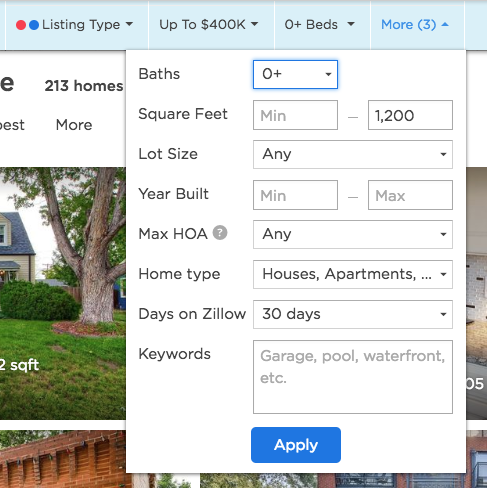
Often a rank based algorithm is provided along with knowledge based recommendations to bring the most popular items in particular categories to the user's attention.

In the next concept, you will get some practice implementing this type of recommendation for the MovieTweetings dataset.

### Recommendations with MovieTweetings: Most Popular Recommendation

Now that you have created the necessary columns we will be using throughout the rest of the lesson on creating recommendations, let's get started with the first of our recommendations.

To get started, read in the libraries and the two datasets you will be using throughout the lesson using the code below.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tests as t

%matplotlib inline

# Read in the datasets
movies = pd.read_csv('movies_clean.csv')
reviews = pd.read_csv('reviews_clean.csv')


#### 1. How To Find The Most Popular Movies

For this notebook, we have a single task.  The task is that no matter the user, we need to provide a list of the recommendations based on simply the most popular items.

For this task, we will consider what is "most popular" based on the following criteria:

* A movie with the highest average rating is considered best
* With ties, movies that have more ratings are better
* A movie must have a minimum of 5 ratings to be considered among the best movies
* If movies are tied in their average rating and number of ratings, the ranking is determined by the movie that is the most recent rating

With these criteria, the goal for this notebook is to take a **user_id** and provide back the **n_top** recommendations.  Use the function below as the scaffolding that will be used for all the future recommendations as well.

In [18]:
def get_recom_df(movies,reviews):
    # A movie with the highest average rating is considered best
    df= reviews.groupby('movie_id').count().reset_index()[['movie_id','user_id']]
    df.columns = ['movie_id', 'count']
    
    # With ties, movies that have more ratings are better
    df['ave_rating'] = reviews.groupby('movie_id').mean().reset_index()['rating']
    
    # If movies are tied in their average rating and number of ratings, the ranking is determined by the movie that is the most recent rating
    df['newest_data'] = reviews.groupby('movie_id').max().reset_index()['date']
    
    # add movie names
    df = df.merge(movies[['movie_id','movie']],how = 'inner', on='movie_id'  )
    
    # A movie must have a minimum of 5 ratings to be considered among the best movies
    df = df[df['count'] >= 5]
    
    # sort the rowes
    df = df.sort_values(by = ['ave_rating','count','newest_data'],ascending = False)   

    return df

recomm = get_recom_df(movies,reviews)

def popular_recommendations(user_id, n_top):
    '''
    INPUT:
    user_id - the user_id of the individual you are making recommendations for
    n_top - an integer of the number recommendations you want back
    OUTPUT:
    top_movies - a list of the n_top recommended movies by movie title in order best to worst
    '''    
    top_movies = list(recomm['movie'][:n_top].values)
    
    return top_movies # a list of the n_top movies as recommended

In [19]:
# Put your solutions for each of the cases here

# Top 20 movies recommended for id 1
recs_20_for_1 = popular_recommendations('1', 20)# Your solution list here

# Top 5 movies recommended for id 53968
recs_5_for_53968 = popular_recommendations('53968', 5)# Your solution list here

# Top 100 movies recommended for id 70000
recs_100_for_70000 = popular_recommendations('70000', 100)# Your solution list here

# Top 35 movies recommended for id 43
recs_35_for_43 = popular_recommendations('43', 35)# Your solution list here


**Notice:** This wasn't the only way we could have determined the "top rated" movies.  You can imagine that in keeping track of trending news or trending social events, you would likely want to create a time window from the current time, and then pull the articles in the most recent time frame.  There are always going to be some subjective decisions to be made.  

If you find that no one is paying any attention to your most popular recommendations, then it might be time to find a new way to recommend, which is what the next parts of the lesson should prepare us to do!


### Part II: Adding Filters

Now that you have created a function to give back the **n_top** movies, let's make it a bit more robust.  Add arguments that will act as filters for the movie **year** and **genre**.  

Use the cells below to adjust your existing function to allow for **year** and **genre** arguments as **lists** of **strings**.  Then your ending results are filtered to only movies within the lists of provided years and genres (as `or` conditions).  If no list is provided, there should be no filter applied.

You can adjust other necessary inputs as necessary to retrieve the final results you are looking for!

Try writing a few tests against the test function in our test function.  Below returns the top 20 movies for user 1 based on the specified year and genre filters.  Does yours return the same? 

```
t.popular_recs_filtered('1', 20, ranked_movies, years=['2015', '2016', '2017', '2018'], genres=['History'])
```

In [20]:
def get_recom_df(movies,reviews):
    # A movie with the highest average rating is considered best
    df= reviews.groupby('movie_id').count().reset_index()[['movie_id','user_id']]
    df.columns = ['movie_id', 'count']
    
    # With ties, movies that have more ratings are better
    df['ave_rating'] = reviews.groupby('movie_id').mean().reset_index()['rating']
    
    # If movies are tied in their average rating and number of ratings, the ranking is determined by the movie that is the most recent rating
    df['newest_data'] = reviews.groupby('movie_id').max().reset_index()['date']
    
    # add movie names
    df = df.merge(movies,how = 'inner', on='movie_id'  )
    
    # A movie must have a minimum of 5 ratings to be considered among the best movies
    df = df[df['count'] >= 5]
    
    # sort the rowes
    df = df.sort_values(by = ['ave_rating','count','newest_data'],ascending = False)   

    return df

recomm = get_recom_df(movies,reviews)


In [21]:
recomm.head()

,movie_id,count,ave_rating,newest_data,movie,genre,date,1800's,1900's,2000's,...,Animation,Family,History,Game-Show,Short,Thriller,Music,Mystery,Talk-Show,Sport
30294,4921860,48,10.0,2016-08-15 03:16:50,MSG 2 the Messenger (2015),Comedy|Drama|Fantasy|Horror,2015,0,0,1,...,0,0,0,0,0,0,0,0,0,0
30957,5262972,28,10.0,2016-01-08 11:44:43,Avengers: Age of Ultron Parody (2015),Short|Comedy,2015,0,0,1,...,0,0,0,0,1,0,0,0,0,0
32972,6662050,22,10.0,2019-04-21 08:29:19,Five Minutes (2017),Short|Comedy,2017,0,0,1,...,0,0,0,0,1,0,0,0,0,0
25130,2737018,10,10.0,2015-05-11 08:56:01,Selam (2013),Drama|Romance,2013,0,0,1,...,0,0,0,0,0,0,0,0,0,0
31790,5804314,7,10.0,2019-12-26 03:27:47,Let There Be Light (2017),Drama,2017,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [22]:
def popular_recommendations(user_id, n_top, movie_df, years_list, genres_list):
    '''
    INPUT:
    user_id - the user_id of the individual you are making recommendations for
    n_top - an integer of the number recommendations you want back
    OUTPUT:
    top_movies - a list of the n_top recommended movies by movie title in order best to worst
    ''' 
    years_list = [int(i) for i in years_list]
    movie_df = movie_df[movie_df['date'].isin(years_list)] 
    
    movie_df = movie_df[movie_df[genres_list].sum(axis = 1) >= 1] # if any genre in the list is not zero
    
    top_movies = list(movie_df['movie'][:n_top].values)
    
    return top_movies # a list of the n_top movies as recommended


In [23]:
a = popular_recommendations('1', 20, recomm, years_list=['2015', '2016', '2017', '2018'], genres_list=['History','Fantasy'])


In [24]:
a

['MSG 2 the Messenger (2015)',
 "Hillary's America: The Secret History of the Democratic Party (2016)",
 'I Believe in Miracles (2015)',
 'Inner Workings (2016)',
 'Sekai kara neko ga kietanara (2016)',
 'Kimi no na wa. (2016)',
 'O.J.: Made in America (2016)',
 'Dayu haitang (2016)',
 'Ayla: The Daughter of War (2017)',
 'Coco (2017)',
 'They Shall Not Grow Old (2018)',
 'Hacksaw Ridge (2016)',
 'Namhansanseong (2017)',
 'The Farthest (2017)',
 'Boku no hîrô akademia THE MOVIE ~ 2-ri no eiyû ~ (2018)',
 'Inside Out (2015)',
 'Kono sekai no katasumi ni (2016)',
 'Sado (2015)',
 'Silicon Cowboys (2016)',
 '13th (2016)']

## More Personalized Recommendations
In some cases, we need to be able to send recommendations without a user telling us exactly what they want or in a more personalized way than simply the top items. Imagine you want to send an email of recommendations or place recommendations within a web page (the side of a blog or as a banner advertisement); in these cases, it is often useful to implement information that we know about users or items to make these recommendations. This leads to some additional recommendation methods!

## Collaborative Filtering and Content Based Recommendations
**Collaborative filtering** is a method of making recommendations based only on the interactions between users and items.

Alternatively, **content based recommendations** are when we use information about the users or items to assist in our recommendations.


- When a user is inputting her/his information (location input), this is an example of **knowledge based recommending**. 
- When we use connections between users and items (connecting Mike and Pradeep as similar), this is an example of **collaborative filtering**. 
- When we use information about the items or users to recommend new items (items related to robotics), this is an example of **content based recommending**.

## Collaborative Filtering
There are two main ways to implement collaborative filtering:

1. Model Based Collaborative Filtering
2. Neighborhood Based Collaborative Filtering

In this lesson, we will cover Neighborhood Based Collaborative Filtering, which is used to identify items or users that are "neighbors" with one another.

There are a number of ways we might go about finding an individual's closest neighbors - the metrics we will take a closer look at include:

1. Pearson's correlation coefficient
2. Spearman's correlation coefficient
3. Kendall's Tau
4. Euclidean Distance
5. Manhattan Distance


### How to Find Your Neighbor?

In neighborhood based collaborative filtering, it is incredibly important to be able to identify an individual's neighbors. Let's look at a small dataset in order to understand how we can use different metrics to identify close neighbors.

In [25]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, kendalltau
import matplotlib.pyplot as plt
import tests as t
import helper as h
%matplotlib inline

play_data = pd.DataFrame({'x1': [-3, -2, -1, 0, 1, 2, 3], 
               'x2': [9, 4, 1, 0, 1, 4, 9],
               'x3': [1, 2, 3, 4, 5, 6, 7],
               'x4': [2, 5, 15, 27, 28, 30, 31]
})

#create play data dataframe
play_data = play_data[['x1', 'x2', 'x3', 'x4']]
play_data

,x1,x2,x3,x4
0,-3,9,1,2
1,-2,4,2,5
2,-1,1,3,15
3,0,0,4,27
4,1,1,5,28
5,2,4,6,30
6,3,9,7,31


### Measures of Similarity

The first metrics we will look at have similar characteristics:

1. Pearson's Correlation Coefficient
2. Spearman's Correlation Coefficient
3. Kendall's Tau

Let's take a look at each of these individually.

### Pearson's Correlation

First, **Pearson's correlation coefficient** is a measure related to the strength and direction of a **linear** relationship.  

If we have two vectors x and y, we can compare their individual elements in the following way to calculate Pearson's correlation coefficient:


$$CORR(\textbf{x}, \textbf{y}) = \frac{\sum\limits_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum\limits_{i=1}^{n}(x_i-\bar{x})^2}\sqrt{\sum\limits_{i=1}^{n}(y_i-\bar{y})^2}} $$

where 

$$\bar{x} = \frac{1}{n}\sum\limits_{i=1}^{n}x_i$$

1. Write a function that takes in two vectors and returns the Pearson correlation coefficient.  You can then compare your answer to the built in function in NumPy by using the assert statements in the following cell.

In [26]:
def pearson_corr(x, y):
    '''
    INPUT
    x - an array of matching length to array y
    y - an array of matching length to array x
    OUTPUT
    corr - the pearson correlation coefficient for comparing x and y
    '''
    x_avg = np.mean(x)
    y_avg = np.mean(y)
    
    corr = ((x - x_avg).multiply(y - x_avg)).sum()/((np.sqrt(((x - x_avg)**2).sum()))*(np.sqrt(((y - y_avg)**2).sum())))
                 
    return corr             

In [27]:
# This cell will test your function against the built in numpy function
assert pearson_corr(play_data['x1'], play_data['x2']) == np.corrcoef(play_data['x1'], play_data['x2'])[0][1], 'Oops!  The correlation between the first two columns should be 0, but your function returned {}.'.format(pearson_corr(play_data['x1'], play_data['x2']))
assert round(pearson_corr(play_data['x1'], play_data['x3']), 2) == np.corrcoef(play_data['x1'], play_data['x3'])[0][1], 'Oops!  The correlation between the first and third columns should be {}, but your function returned {}.'.format(np.corrcoef(play_data['x1'], play_data['x3'])[0][1], pearson_corr(play_data['x1'], play_data['x3']))
assert round(pearson_corr(play_data['x3'], play_data['x4']), 2) == round(np.corrcoef(play_data['x3'], play_data['x4'])[0][1], 2), 'Oops!  The correlation between the first and third columns should be {}, but your function returned {}.'.format(np.corrcoef(play_data['x3'], play_data['x4'])[0][1], pearson_corr(play_data['x3'], play_data['x4']))
print("If this is all you see, it looks like you are all set!  Nice job coding up Pearson's correlation coefficient!")


If this is all you see, it looks like you are all set!  Nice job coding up Pearson's correlation coefficient!


In [28]:
import scipy.stats as stats

stats.pearsonr(play_data['x1'], 5*play_data['x2'])[0]

0.0

### Spearman's Correlation

Now, let's look at **Spearman's correlation coefficient**. Spearman's correlation is what is known as a [non-parametric](https://en.wikipedia.org/wiki/Nonparametric_statistics) statistic, which is a statistic whose distribution doesn't depend on parameters. (Statistics that follow normal distributions or binomial distributions are examples of parametric statistics.)  

Frequently non-parametric statistics are based on the ranks of data rather than the original values collected.  This happens to be the case with Spearman's correlation coefficient, which is calculated similarly to Pearson's correlation.  However, instead of using the raw data, we use the rank of each value.

You can quickly change from the raw data to the ranks using the **.rank()** method as shown here:

In [29]:
print("The ranked values for the variable x1 are: {}".format(np.array(play_data['x1'].rank())))
print("The raw data values for the variable x1 are: {}".format(np.array(play_data['x1'])))

The ranked values for the variable x1 are: [1. 2. 3. 4. 5. 6. 7.]
The raw data values for the variable x1 are: [-3 -2 -1  0  1  2  3]


If we map each of our data to ranked data values as shown above:

$$\textbf{x} \rightarrow \textbf{x}^{r}$$
$$\textbf{y} \rightarrow \textbf{y}^{r}$$

Here, we let the **r** indicate these are ranked values (this is not raising any value to the power of r).  Then we compute Spearman's correlation coefficient as:

$$SCORR(\textbf{x}, \textbf{y}) = \frac{\sum\limits_{i=1}^{n}(x^{r}_i - \bar{x}^{r})(y^{r}_i - \bar{y}^{r})}{\sqrt{\sum\limits_{i=1}^{n}(x^{r}_i-\bar{x}^{r})^2}\sqrt{\sum\limits_{i=1}^{n}(y^{r}_i-\bar{y}^{r})^2}} $$

where 

$$\bar{x}^r = \frac{1}{n}\sum\limits_{i=1}^{n}x^r_i$$

`3.` Write a function that takes in two vectors and returns the Spearman correlation coefficient.  You can then compare your answer to the built in function in scipy stats by using the assert statements in the following cell.

In [30]:
def corr_spearman(x, y):
    '''
    INPUT
    x - an array of matching length to array y
    y - an array of matching length to array x
    OUTPUT
    corr - the spearman correlation coefficient for comparing x and y
    '''
    x_r = x.rank()
    y_r = y.rank()    
    x_r_avg = x.rank().mean()    
    y_r_avg = y.rank().mean()    
    
    corr = ((x_r - x_r_avg).multiply(y_r - y_r_avg)).sum()/((np.sqrt(((x_r - x_r_avg)**2).sum()))*\
                                                            (np.sqrt(((y_r - y_r_avg)**2).sum())))
   
    
    return corr  

In [31]:
# This cell will test your function against the built in scipy function
assert corr_spearman(play_data['x1'], play_data['x2']) == spearmanr(play_data['x1'], play_data['x2'])[0], 'Oops!  The correlation between the first two columns should be 0, but your function returned {}.'.format(compute_corr(play_data['x1'], play_data['x2']))
assert round(corr_spearman(play_data['x1'], play_data['x3']), 2) == spearmanr(play_data['x1'], play_data['x3'])[0], 'Oops!  The correlation between the first and third columns should be {}, but your function returned {}.'.format(np.corrcoef(play_data['x1'], play_data['x3'])[0][1], compute_corr(play_data['x1'], play_data['x3']))
assert round(corr_spearman(play_data['x3'], play_data['x4']), 2) == round(spearmanr(play_data['x3'], play_data['x4'])[0], 2), 'Oops!  The correlation between the first and third columns should be {}, but your function returned {}.'.format(np.corrcoef(play_data['x3'], play_data['x4'])[0][1], compute_corr(play_data['x3'], play_data['x4']))
print("If this is all you see, it looks like you are all set!  Nice job coding up Spearman's correlation coefficient!")


If this is all you see, it looks like you are all set!  Nice job coding up Spearman's correlation coefficient!


Unlike Pearson's correlation, Spearman's correlation can have perfect relationships (1 or -1 values) that aren't linear relationships.  You will notice that neither Spearman or Pearson correlation values suggest a relation when there are quadratic relationships.

### Kendall's Tau

Kendall's tau is quite similar to Spearman's correlation coefficient.  Both of these measures are non-parametric measures of a relationship.  Specifically both Spearman and Kendall's coefficients are calculated based on ranking data and not the raw data.  

Similar to both of the previous measures, Kendall's Tau is always between -1 and 1, where -1 suggests a strong, negative relationship between two variables and 1 suggests a strong, positive relationship between two variables.

Though Spearman's and Kendall's measures are very similar, there are statistical advantages to choosing Kendall's measure in that Kendall's Tau has smaller variability when using larger sample sizes.  However Spearman's measure is more computationally efficient, as Kendall's Tau is O(n^2) and Spearman's correlation is O(nLog(n)). You can find more on this topic in [this thread](https://www.researchgate.net/post/Does_Spearmans_rho_have_any_advantage_over_Kendalls_tau).

Let's take a closer look at exactly how this measure is calculated.  Again, we want to map our data to ranks:

$$\textbf{x} \rightarrow \textbf{x}^{r}$$
$$\textbf{y} \rightarrow \textbf{y}^{r}$$

Then we calculate Kendall's Tau as:

令（x 1，  y 1），（x 2，  y 2），...，（x n，  y n）分别是联合随机变量X和Y的一组观察值，使得所有值（的））和（）是独一无二的。任何一对观察 和 ，哪里 ，被认为是一致的，如果两个元件的行列（更精确地，由所述排序顺序X和由ÿ）同意：即，如果两个 和 ; 或两者兼而有之 和。他们被认为是不和谐的，如果 和 ; 或者如果 和。如果 要么，这对既不和谐也不矛盾。


$$TAU(\textbf{x}, \textbf{y}) = \frac{2}{n(n -1)}\sum_{i < j}sgn(x^r_i - x^r_j)sgn(y^r_i - y^r_j)$$

Where $sgn$ takes the the sign associated with the difference in the ranked values.  An alternative way to write 

$$sgn(x^r_i - x^r_j)$$ 

is in the following way:

$$
 \begin{cases} 
      -1  & x^r_i < x^r_j \\
      0 & x^r_i = x^r_j \\
      1 & x^r_i > x^r_j 
   \end{cases}
$$

Therefore the possible results of 

$$sgn(x^r_i - x^r_j)sgn(y^r_i - y^r_j)$$

are only 1, -1, or 0, which are summed to give an idea of the proportion of times the ranks of **x** and **y** are pointed in the right direction.

`5.` Write a function that takes in two vectors and returns Kendall's Tau.  You can then compare your answer to the built in function in scipy stats by using the assert statements in the following cell.

In [32]:
def kendalls_tau(x, y):
    '''
    INPUT
    x - an array of matching length to array y
    y - an array of matching length to array x
    OUTPUT
    tau - the kendall's tau for comparing x and y
    '''    
    n = len(x)
    x_r = x.rank()
    y_r = y.rank()
    
    sgn = lambda a,b : -1 if a<b else (0 if a ==b else 1)
    
    sgns = []
    for j in range(len(x)):
        for i in range(j):
            sgns.append((sgn(x_r[i],x_r[j]))*(sgn(y_r[i],y_r[j])))
            
    tau = np.sum(sgns)*(2/(n*(n-1)))
    
    return tau

In [33]:
# This cell will test your function against the built in scipy function
assert kendalls_tau(play_data['x1'], play_data['x2']) == kendalltau(play_data['x1'], play_data['x2'])[0], 'Oops!  The correlation between the first two columns should be 0, but your function returned {}.'.format(kendalls_tau(play_data['x1'], play_data['x2']))
assert round(kendalls_tau(play_data['x1'], play_data['x3']), 2) == kendalltau(play_data['x1'], play_data['x3'])[0], 'Oops!  The correlation between the first and third columns should be {}, but your function returned {}.'.format(kendalltau(play_data['x1'], play_data['x3'])[0][1], kendalls_tau(play_data['x1'], play_data['x3']))
assert round(kendalls_tau(play_data['x3'], play_data['x4']), 2) == round(kendalltau(play_data['x3'], play_data['x4'])[0], 2), 'Oops!  The correlation between the first and third columns should be {}, but your function returned {}.'.format(kendalltau(play_data['x3'], play_data['x4'])[0][1], kendalls_tau(play_data['x3'], play_data['x4']))
print("If this is all you see, it looks like you are all set!  Nice job coding up Kendall's Tau!")


If this is all you see, it looks like you are all set!  Nice job coding up Kendall's Tau!


In [34]:
print(pearson_corr(play_data['x1'], play_data['x2']))
print(pearson_corr(play_data['x1'], play_data['x3']))
print(pearson_corr(play_data['x1'], play_data['x4']))
print(pearson_corr(play_data['x2'], play_data['x3']))
print(pearson_corr(play_data['x2'], play_data['x4']))
print(pearson_corr(play_data['x3'], play_data['x4']))
print('----')
print(corr_spearman(play_data['x1'], play_data['x2']))
print(corr_spearman(play_data['x1'], play_data['x3']))
print(corr_spearman(play_data['x1'], play_data['x4']))
print(corr_spearman(play_data['x2'], play_data['x3']))
print(corr_spearman(play_data['x2'], play_data['x4']))
print(corr_spearman(play_data['x3'], play_data['x4']))
print('----')
print(kendalls_tau(play_data['x1'], play_data['x2']))
print(kendalls_tau(play_data['x1'], play_data['x3']))
print(kendalls_tau(play_data['x1'], play_data['x4']))
print(kendalls_tau(play_data['x2'], play_data['x3']))
print(kendalls_tau(play_data['x2'], play_data['x4']))
print(kendalls_tau(play_data['x3'], play_data['x4']))

0.0
0.9999999999999999
0.9410355248034292
0.0
-0.26078741450988513
0.9410355248034292
----
0.0
0.9999999999999999
0.9999999999999999
0.0
0.0
0.9999999999999999
----
0.0
1.0
1.0
0.0
0.0
1.0


Pearson does not match the other two measures, as it looks specifically for linear relationships.  However, Spearman and Kenall's measures are exactly the same to one another in the cases related to play_data.

### Distance Measures

All of the above measures are considered measures of correlation.  Similarly, there are distance measures (of which there are many).  [This is a great article](http://dataaspirant.com/2015/04/11/five-most-popular-similarity-measures-implementation-in-python/) on some popular distance metrics.  In this notebook, we will be looking specifically at two of these measures.  

1. Euclidean Distance
2. Manhattan Distance

Different than the three measures you built functions for, these two measures take on values between 0 and potentially infinity.  Measures that are closer to 0 imply that two vectors are more similar to one another.  The larger these values become, the more dissimilar two vectors are to one another.

Choosing one of these two `distance` metrics vs. one of the three `similarity` above is often a matter of personal preference, audience, and data specificities.  You will see in a bit a case where one of these measures (euclidean or manhattan distance) is optimal to using Pearson's correlation coefficient.

### Euclidean Distance

Euclidean distance can also just be considered as straight-line distance between two vectors.

For two vectors **x** and **y**, we can compute this as:

$$ EUC(\textbf{x}, \textbf{y}) = \sqrt{\sum\limits_{i=1}^{n}(x_i - y_i)^2}$$

### Manhattan Distance

Different from euclidean distance, Manhattan distance is a 'manhattan block' distance from one vector to another.  Therefore, you can imagine this distance as a way to compute the distance between two points when you are not able to go through buildings.

Specifically, this distance is computed as:

$$ MANHATTAN(\textbf{x}, \textbf{y}) = \sum\limits_{i=1}^{n}|x_i - y_i|$$

Using each of the above, write a function for each to take two vectors and compute the euclidean and manhattan distances.
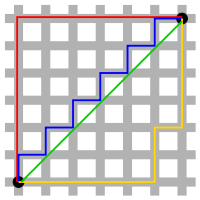

You can see in the above image, the **blue** line gives the **Manhattan** distance, while the **green** line gives the **Euclidean** distance between two points.

`7.` Use the below cell to complete a function for each distance metric.  Then test your functions against the built in values using the below.

In [35]:
def eucl_dist(x, y):
    '''
    INPUT
    x - an array of matching length to array y
    y - an array of matching length to array x
    OUTPUT
    euc - the euclidean distance between x and y
    ''' 
    return np.sqrt(sum((x-y)**2))

    
    
def manhat_dist(x, y):
    '''
    INPUT
    x - an array of matching length to array y
    y - an array of matching length to array x
    OUTPUT
    manhat - the manhattan distance between x and y
    '''  
    return sum(np.abs(x-y))


In [36]:
# Test your functions
assert h.test_eucl(play_data['x1'], play_data['x2']) == eucl_dist(play_data['x1'], play_data['x2'])
assert h.test_eucl(play_data['x2'], play_data['x3']) == eucl_dist(play_data['x2'], play_data['x3'])
assert h.test_manhat(play_data['x1'], play_data['x2']) == manhat_dist(play_data['x1'], play_data['x2'])
assert h.test_manhat(play_data['x2'], play_data['x3']) == manhat_dist(play_data['x2'], play_data['x3'])


### Final Note

It is worth noting that two vectors could be similar by metrics like the three at the top of the notebook, while being incredibly, incredibly different by measures like these final two.  Again, understanding your specific situation will assist in understanding whether your metric is appropriate.

## Making Recommendations
Finalizing our neighborhood based recommendations, we need to use the ratings from our neighbors to influence the ratings we provide to other users.

There are a few ways to do this, but a simple method would be to:

1. Remove movies our user has already seen.
2. Find ratings of the neighbors that are high.
3. Recommend movies to each user where both 1 and 2 above hold.

Other methods for making recommendations using collaborative filtering are based on weighting of the neighbors' ratings based on the 'closeness' of the neighbors.

You can use each of the following two papers to learn more about this technique:

1. [Domino Data Lab Paper](https://blog.dominodatalab.com/recommender-systems-collaborative-filtering/)
2. [Semantic Scholar Paper On Weighted Ratings](https://pdfs.semanticscholar.org/3e9e/bcd9503ef7375c7bb334511804d1e45127e9.pdf)

## Recommendations with MovieTweetings: Collaborative Filtering

One of the most popular methods for making recommendations is **collaborative filtering**.  In collaborative filtering, you are using the collaboration of user-item recommendations to assist in making new recommendations.  

There are two main methods of performing collaborative filtering:

1. **Neighborhood-Based Collaborative Filtering**, which is based on the idea that we can either correlate items that are similar to provide recommendations or we can correlate users to one another to provide recommendations.

2. **Model Based Collaborative Filtering**, which is based on the idea that we can use machine learning and other mathematical models to understand the relationships that exist amongst items and users to predict ratings and provide ratings.


In this notebook, you will be working on performing **neighborhood-based collaborative filtering**.  There are two main methods for performing collaborative filtering:

1. **User-based collaborative filtering:** In this type of recommendation, users related to the user you would like to make recommendations for are used to create a recommendation.

2. **Item-based collaborative filtering:** In this type of recommendation, first you need to find the items that are most related to each other item (based on similar ratings).  Then you can use the ratings of an individual on those similar items to understand if a user will like the new item.

In this notebook you will be implementing **user-based collaborative filtering**.  However, it is easy to extend this approach to make recommendations using **item-based collaborative filtering**.  First, let's read in our data and necessary libraries.

**NOTE**: Because of the size of the datasets, some of your code cells here will take a while to execute, so be patient!

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import progressbar
from scipy.sparse import csr_matrix
from IPython.display import HTML


%matplotlib inline

# Read in the datasets
movies = pd.read_csv('movies_clean.csv')
reviews = pd.read_csv('reviews_clean.csv')

print(reviews.head())

   user_id  movie_id  rating   timestamp                 date  month_1  \
0        1    114508       8  1381006850  2013-10-06 08:00:50    False   
1        2    358273       9  1579057827  2020-01-15 14:10:27     True   
2        2  10039344       5  1578603053  2020-01-10 07:50:53     True   
3        2   6751668       9  1578955697  2020-01-14 09:48:17     True   
4        2   7131622       8  1579559244  2020-01-21 09:27:24     True   

   month_2  month_3  month_4  month_5  ...  month_11  month_12  year_2013  \
0    False    False    False    False  ...     False     False       True   
1    False    False    False    False  ...     False     False      False   
2    False    False    False    False  ...     False     False      False   
3    False    False    False    False  ...     False     False      False   
4    False    False    False    False  ...     False     False      False   

   year_2014  year_2015  year_2016  year_2017  year_2018  year_2019  year_2020  
0      Fals

### Measures of Similarity

When using **neighborhood** based collaborative filtering, it is important to understand how to measure the similarity of users or items to one another.  

There are a number of ways in which we might measure the similarity between two vectors (which might be two users or two items).  In this notebook, we will look specifically at two measures used to compare vectors:

* **Pearson's correlation coefficient**

Pearson's correlation coefficient is a measure of the strength and direction of a linear relationship. The value for this coefficient is a value between -1 and 1 where -1 indicates a strong, negative linear relationship and 1 indicates a strong, positive linear relationship. 

If we have two vectors x and y, we can define the correlation between the vectors as:


$$CORR(x, y) = \frac{\text{COV}(x, y)}{\text{STDEV}(x)\text{ }\text{STDEV}(y)}$$

where 

$$\text{STDEV}(x) = \sqrt{\frac{1}{n-1}\sum_{i=1}^{n}(x_i - \bar{x})^2}$$

and 

$$\text{COV}(x, y) = \frac{1}{n-1}\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})$$

where n is the length of the vector, which must be the same for both x and y and $\bar{x}$ is the mean of the observations in the vector.  

We can use the correlation coefficient to indicate how alike two vectors are to one another, where the closer to 1 the coefficient, the more alike the vectors are to one another.  There are some potential downsides to using this metric as a measure of similarity.  You will see some of these throughout this workbook.


* **Euclidean distance**

Euclidean distance is a measure of the straightline distance from one vector to another.  Because this is a measure of distance, larger values are an indication that two vectors are different from one another (which is different than Pearson's correlation coefficient).

Specifically, the euclidean distance between two vectors x and y is measured as:

$$ \text{EUCL}(x, y) = \sqrt{\sum_{i=1}^{n}(x_i - y_i)^2}$$

Different from the correlation coefficient, no scaling is performed in the denominator.  Therefore, you need to make sure all of your data are on the same scale when using this metric.

**Note:** Because measuring similarity is often based on looking at the distance between vectors, it is important in these cases to scale your data or to have all data be in the same scale.  If some measures are on a 5 point scale, while others are on a 100 point scale, you are likely to have non-optimal results due to the difference in variability of your features.  In this case, we will not need to scale data because they are all on a 10 point scale, but it is always something to keep in mind!

------------

### User-Item Matrix

In order to calculate the similarities, it is common to put values in a matrix.  In this matrix, users are identified by each row, and items are represented by columns.  


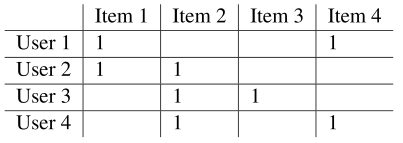

In the above matrix, you can see that **User 1** and **User 2** both used **Item 1**, and **User 2**, **User 3**, and **User 4** all used **Item 2**.  However, there are also a large number of missing values in the matrix for users who haven't used a particular item.  A matrix with many missing values (like the one above) is considered **sparse**.

Our first goal for this notebook is to create the above matrix with the **reviews** dataset.  However, instead of 1 values in each cell, you should have the actual rating.  

The users will indicate the rows, and the movies will exist across the columns. To create the user-item matrix, we only need the first three columns of the **reviews** dataframe, which you can see by running the cell below.

In [2]:
user_items = reviews[['user_id', 'movie_id', 'rating']]
user_items.head()

,user_id,movie_id,rating
0,1,114508,8
1,2,358273,9
2,2,10039344,5
3,2,6751668,9
4,2,7131622,8


### Creating the User-Item Matrix

In order to create the user-items matrix (like the one above), I personally started by using a [pivot table](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html). 

However, I quickly ran into a memory error (a common theme throughout this notebook).  I will help you navigate around many of the errors I had, and achieve useful collaborative filtering results! 

_____

`1.` Create a matrix where the users are the rows, the movies are the columns, and the ratings exist in each cell, or a NaN exists in cells where a user hasn't rated a particular movie. If you get a memory error (like I did), [this link here](https://stackoverflow.com/questions/39648991/pandas-dataframe-pivot-memory-error) might help you!

In [3]:
# in order to avoide "Unstacked DataFrame is too big, causing int32 overflow"
# open the reshape.py (~/opt/anaconda3/lib/python3.7/site-packages/pandas/cpre/reshape)
# change num_cells = np.multiply(num_rows, num_columns, dtype=np.int32) to dtype=np.int64

user_by_movie = user_items.groupby(['user_id', 'movie_id'])['rating'].max().unstack()

In [6]:
movies[(movies.movie_id == 106519) | (movies.movie_id == 1979376)]

,movie_id,movie,genre,date,1800's,1900's,2000's,Comedy,Action,Biography,...,Animation,Family,History,Game-Show,Short,Thriller,Music,Mystery,Talk-Show,Sport
8083,106519,Carlito's Way (1993),NaN,1993,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8084,106519,Carlito's Way (1993),Crime|Drama|Thriller,1993,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
21606,1979376,Toy Story 4 (2019),Animation|Adventure|Comedy|Family|Fantasy,2019,0,0,1,1,0,0,...,1,1,0,0,0,0,0,0,0,0
21607,1979376,Toy Story 4 (2019),Animation|Adventure|Comedy|Family|Fantasy,2019,0,0,1,1,0,0,...,1,1,0,0,0,0,0,0,0,0


In [4]:
# there are two movies are duplicated (106519 and 1979376), so movies.shape[0]-2
assert movies.shape[0]-2 == user_by_movie.shape[1], "Oh no! Your matrix should have {} columns, and yours has {}!".format(movies.shape[0], user_by_movie.shape[1])
assert reviews.user_id.nunique() == user_by_movie.shape[0], "Oh no! Your matrix should have {} rows, and yours has {}!".format(reviews.user_id.nunique(), user_by_movie.shape[0])
print("Looks like you are all set! Proceed!")

Looks like you are all set! Proceed!


In [49]:
# Create a dictionary with users and corresponding movies seen

def movies_watched(user_id):
    '''
    INPUT:
    user_id - the user_id of an individual as int
    OUTPUT:
    movies - an array of movies the user has watched
    '''
    movies = user_by_movie.loc[user_id][user_by_movie.loc[user_id].isnull() == False].index.values

    return movies


def create_user_movie_dict():
    '''
    INPUT: None
    OUTPUT: movies_seen - a dictionary where each key is a user_id and the value is an array of movie_ids
    
    Creates the movies_seen dictionary
    '''
    movies_seen = {}
    
    for i in user_by_movie.index.values:        
        movies_seen[i] = list(movies_watched(i))
    
    return movies_seen


# Use your function to return dictionary
movies_seen = create_user_movie_dict(user_by_movie)


`3.` If a user hasn't rated more than 2 movies, we consider these users "too new".  Create a new dictionary that only contains users who have rated more than 2 movies.  This dictionary will be used for all the final steps of this workbook.

In [8]:
# Remove individuals who have watched 2 or fewer movies - don't have enough data to make recs

def create_movies_to_analyze(movies_seen, lower_bound=2):
    '''
    INPUT:  
    movies_seen - a dictionary where each key is a user_id and the value is an array of movie_ids
    lower_bound - (an int) a user must have more movies seen than the lower bound to be added to the movies_to_analyze dictionary

    OUTPUT: 
    movies_to_analyze - a dictionary where each key is a user_id and the value is an array of movie_ids
    
    The movies_seen and movies_to_analyze dictionaries should be the same except that the output dictionary has removed 
    
    '''
    movies_to_analyze = {}
    for user_id,movies in movies_seen.items():
        if len(movies) > lower_bound:
            movies_to_analyze[user_id] = movies
    # Do things to create updated dictionary
    
    return movies_to_analyze


# Use your function to return your updated dictionary
movies_to_analyze = create_movies_to_analyze(movies_seen)


In [9]:
len(movies_to_analyze)

29343

### Calculating User Similarities

Now that you have set up the **movies_to_analyze** dictionary, it is time to take a closer look at the similarities between users.  Below is the pseudocode for how I thought about determining the similarity between users:

```
for user1 in movies_to_analyze
    for user2 in movies_to_analyze
        see how many movies match between the two users
        if more than two movies in common
            pull the overlapping movies
            compute the distance/similarity metric between ratings on the same movies for the two users
            store the users and the distance metric
```

However, this took a very long time to run, and other methods of performing these operations did not fit on the workspace memory!

Therefore, rather than creating a dataframe with all possible pairings of users in our data, your task for this question is to look at a few specific examples of the correlation between ratings given by two users.  For this question consider you want to compute the [correlation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) between users.

`4.` Using the **movies_to_analyze** dictionary and **user_by_movie** dataframe, create a function that computes the correlation between the ratings of similar movies for two users.  Then use your function to compare your results to ours using the tests below.  

In [22]:
def compute_correlation(user1, user2):
    '''
    INPUT
    user1 - int user_id
    user2 - int user_id
    OUTPUT
    the correlation between the matching ratings between the two users
    '''
    # Pull movies for each user
    movies1 = movies_to_analyze[user1]
    movies2 = movies_to_analyze[user2]
    
    # Find Similar Movies
    sim_movs = np.intersect1d(movies1, movies2, assume_unique=True)

    # Calculate correlation between the users
    df = user_by_movie.loc[(user1, user2), sim_movs]
    corr = df.transpose().corr().iloc[0,1]
  
    return corr #return the correlation

compute_correlation(28,85)

0.21063058936525558

In [25]:
compute_correlation(2,103)

nan

In [26]:
# Test your function against the solution
assert compute_correlation(2,2) == 1.0, "Oops!  The correlation between a user and itself should be 1.0."
#assert round(compute_correlation('2','66'), 2) == 0.76, "Oops!  The correlation between user 2 and 66 should be about 0.76."
assert np.isnan(compute_correlation(2,103)), "Oops!  The correlation between user 2 and 104 should be a NaN."

print("If this is all you see, then it looks like your function passed all of our tests!")

If this is all you see, then it looks like your function passed all of our tests!


### Why the NaN's?

If the function you wrote passed all of the tests, then you have correctly set up your function to calculate the correlation between any two users.  

`5.` But one question is, why are we still obtaining **NaN** values?  As you can see in the code cell above, users 2 and 104 have a correlation of **NaN**. Why?

Think and write your ideas here about why these NaNs exist, and use the cells below to do some coding to validate your thoughts. You can check other pairs of users and see that there are actually many NaNs in our data - 2,526,710 of them in fact. These NaN's ultimately make the correlation coefficient a less than optimal measure of similarity between two users.

```
User id 2 's common movies are all give score of 8.0 ,this will leads to a zero stdev, leads a corr to null.
```

`6.` Because the correlation coefficient proved to be less than optimal for relating user ratings to one another, we could instead calculate the euclidean distance between the ratings.  I found [this post](https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy) particularly helpful when I was setting up my function.  This function should be very similar to your previous function.  When you feel confident with your function, test it against our results.

In [27]:
def compute_euclidean_dist(user1, user2):
    '''
    INPUT
    user1 - int user_id
    user2 - int user_id
    OUTPUT
    the euclidean distance between user1 and user2
    '''
    # Pull movies for each user
    movies1 = movies_to_analyze[user1]
    movies2 = movies_to_analyze[user2]
    
    # Find Similar Movies
    sim_movs = np.intersect1d(movies1, movies2, assume_unique=True)

    # Calculate correlation between the users
    df = user_by_movie.loc[(user1, user2), sim_movs]
    dist = np.linalg.norm(df.loc[user1] - df.loc[user2])
   
    return dist #return the euclidean distance


In [28]:
compute_euclidean_dist(28,49)

5.0990195135927845

Next, we need to build a dataframe with 3 columns, one is user1 one is user2, and the third column is the euclidean_dist of the two user, for the dataset is too large

In [43]:
# Read in solution euclidean distances
import pickle
df_dists = pd.read_pickle("dists.p")

In [44]:
df_dists.head()

,user1,user2,eucl_dist
0,2,2,0.000000
1,2,66,2.236068
2,2,90,5.385165
3,2,99,2.828427
4,2,104,2.000000


### Using the Nearest Neighbors to Make Recommendations

In the previous question, you read in **df_dists**. Therefore, you have a measure of distance between each user and every other user. This dataframe holds every possible pairing of users, as well as the corresponding euclidean distance.

Because of the **NaN** values that exist within the correlations of the matching ratings for many pairs of users, as we discussed above, we will proceed using **df_dists**. You will want to find the users that are 'nearest' each user.  Then you will want to find the movies the closest neighbors have liked to recommend to each user.

I made use of the following objects:

* df_dists (to obtain the neighbors)
* user_items (to obtain the movies the neighbors and users have rated)
* movies (to obtain the names of the movies)

`7.` Complete the functions below, which allow you to find the recommendations for any user.  There are five functions which you will need:

* **find_closest_neighbors** - this returns a list of user_ids from closest neighbor to farthest neighbor using euclidean distance


* **movies_liked** - returns an array of movie_ids


* **movie_names** - takes the output of movies_liked and returns a list of movie names associated with the movie_ids


* **make_recommendations** - takes a user id and goes through closest neighbors to return a list of movie names as recommendations


* **all_recommendations** = loops through every user and returns a dictionary of with the key as a user_id and the value as a list of movie recommendations

In [63]:
def find_closest_neighbors(user):
    '''
    INPUT:
        user - (int) the user_id of the individual you want to find the closest users
    OUTPUT:
        closest_neighbors - an array of the id's of the users sorted from closest to farthest away
    '''
    # I treated ties as arbitrary and just kept whichever was easiest to keep using the head method
    # You might choose to do something less hand wavy
    
    closest_users = df_dists[df_dists['user1']==user].sort_values(by='eucl_dist').iloc[1:]['user2']
    closest_neighbors = np.array(closest_users)
    
    return closest_neighbors
    
    
    
def movies_liked(user_id, min_rating=7):
    '''
    INPUT:
    user_id - the user_id of an individual as int
    min_rating - the minimum rating considered while still a movie is still a "like" and not a "dislike"
    OUTPUT:
    movies_liked - an array of movies the user has watched and liked
    '''
    movies_liked = np.array(user_items.query('user_id == @user_id and rating > (@min_rating -1)')['movie_id'])
    
    return movies_liked


def movie_names(movie_ids):
    '''
    INPUT
    movie_ids - a list of movie_ids
    OUTPUT
    movies - a list of movie names associated with the movie_ids
    
    '''
    movie_lst = list(movies[movies['movie_id'].isin(movie_ids)]['movie'])
   
    return movie_lst
    
    
def make_recommendations(user, num_recs=10):
    '''
    INPUT:
        user - (int) a user_id of the individual you want to make recommendations for
        num_recs - (int) number of movies to return
    OUTPUT:
        recommendations - a list of movies - if there are "num_recs" recommendations return this many
                          otherwise return the total number of recommendations available for the "user"
                          which may just be an empty list
    '''
    # I wanted to make recommendations by pulling different movies than the user has already seen
    # Go in order from closest to farthest to find movies you would recommend
    # I also only considered movies where the closest user rated the movie as a 9 or 10
    
    # movies_seen by user (we don't want to recommend these)
    movies_seen = movies_watched(user)
    closest_neighbors = find_closest_neighbors(user)
    
    # Keep the recommended movies here
    recs = np.array([])
    
    # Go through the neighbors and identify movies they like the user hasn't seen
    for neighbor in closest_neighbors:
        neighbs_likes = movies_liked(neighbor)
        
        #Obtain recommendations for each neighbor
        new_recs = np.setdiff1d(neighbs_likes, movies_seen, assume_unique=True)
        
        # Update recs with new recs
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        
        # If we have enough recommendations exit the loop
        if len(recs) > num_recs-1:
            break
    
    # Pull movie titles using movie ids
    recommendations = movie_names(recs)
    
    return recommendations

def all_recommendations(num_recs=10):
    '''
    INPUT 
        num_recs (int) the (max) number of recommendations for each user
    OUTPUT
        all_recs - a dictionary where each key is a user_id and the value is an array of recommended movie titles
    '''
    
    # All the users we need to make recommendations for
    users = np.unique(df_dists['user1'])
    n_users = len(users)
    
    #Store all recommendations in this dictionary
    all_recs = dict()
    
    # Make the recommendations for each user
    cnter = 0
    bar = progressbar.ProgressBar(maxval = n_users+1, widgets = [progressbar.Bar('=','[',']'),'', progressbar.Percentage()])
    bar.start()
    
    for user in users:
        cnter += 1
        all_recs[user] = make_recommendations(user, num_recs)
    
    bar.finish()
    
    return all_recs

all_recs = all_recommendations(10)


[=========================================================================]100%


In [70]:
import pickle

with open('all_recs.p', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(all_recs, f)

In [71]:
all_recs2 = pd.read_pickle("all_recs.p")

In [72]:
all_recs2

{2: ['Koyaanisqatsi (1982)',
  'Plata quemada (2000)',
  'La piel que habito (2011)',
  'Hillary: The Movie (2008)',
  'Que se mueran los feos (2010)',
  'Lo imposible (2012)',
  'My Week with Marilyn (2011)',
  'El cuerpo (2012)',
  'Hating Breitbart (2012)',
  'Café Society (2016)'],
 3: ["All the President's Men (1976)",
  'Star Wars (1977)',
  'Star Wars: Episode V - The Empire Strikes Back (1980)',
  'Raiders of the Lost Ark (1981)',
  'Blade Runner (1982)',
  'Star Wars: Episode VI - Return of the Jedi (1983)',
  'Brazil (1985)',
  'Dead Poets Society (1989)',
  'Indiana Jones and the Last Crusade (1989)',
  'Much Ado About Nothing (1993)',
  'Clear and Present Danger (1994)',
  'Sense and Sensibility (1995)',
  'The Usual Suspects (1995)',
  'A Time to Kill (1996)',
  'Star Wars: Episode III - Revenge of the Sith (2005)',
  'Shakespeare in Love (1998)',
  'American Psycho (2000)',
  'Almost Famous (2000)',
  'Memento (2000)',
  'The Bourne Identity (2002)',
  'Master and Command

## Content Based Recommendations
In the previous notebook, you implemented collaborative filtering to make recommendations based on finding similar users. However, there were a number of users who did not receive recommendations when using this technique. For this reason, we might use other recommendation techniques to find items to recommend to users.

Another popular technique for making recommendations is called content based recommendations. In this recommendation technique, we use information that is known about the user or item to make recommendations. This method of making recommendations is particularly useful when we do not have a lot of user-item connections available in our dataset.

It might be the case that content based and collaborative filtering based techniques come up with similar recommendations, but the methods by which data scientists approach these recommendations are very different. In collaborative filtering, you are using the connections of users and items (as you did before). In content based techniques, you are using information about the users and items, but not connections (hence the usefulness when you do not have a lot of internal data already available to use).

Let's take a look at how we might implement this method with the MovieTweetings data.

### Content Based Recommendations

In the previous notebook, you were introduced to a way of making recommendations using collaborative filtering.  However, using this technique there are a large number of users who were left without any recommendations at all.  Other users were left with fewer than the ten recommendations that were set up by our function to retrieve....

In order to help these users out, let's try another technique: **content based** recommendations. Let's start off where we were in the previous notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import HTML
import progressbar
import tests as t
import pickle


%matplotlib inline


In [2]:
# Read in the datasets
movies = pd.read_csv('movies_clean1.csv')
reviews = pd.read_csv('reviews_clean1.csv')

del movies['Unnamed: 0']
del reviews['Unnamed: 0']


In [3]:
all_recs = pickle.load(open("all_recs1.p", "rb"))

In [80]:
set(users).difference(set(all_recs.keys()))

{1,
 4,
 5,
 6,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 18,
 19,
 20,
 21,
 23,
 27,
 28,
 29,
 35,
 36,
 37,
 38,
 40,
 41,
 46,
 47,
 49,
 50,
 56,
 58,
 59,
 60,
 62,
 63,
 65,
 67,
 68,
 69,
 70,
 72,
 76,
 78,
 80,
 81,
 82,
 83,
 84,
 87,
 88,
 91,
 92,
 93,
 94,
 95,
 98,
 100,
 103,
 105,
 107,
 110,
 111,
 113,
 114,
 115,
 116,
 117,
 118,
 120,
 123,
 126,
 127,
 128,
 131,
 132,
 133,
 134,
 137,
 142,
 143,
 144,
 145,
 148,
 150,
 151,
 153,
 154,
 160,
 161,
 163,
 165,
 167,
 168,
 169,
 170,
 172,
 173,
 176,
 177,
 178,
 179,
 182,
 184,
 185,
 186,
 188,
 189,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 203,
 204,
 205,
 210,
 211,
 213,
 215,
 216,
 217,
 218,
 220,
 222,
 223,
 226,
 229,
 231,
 232,
 233,
 234,
 236,
 237,
 239,
 241,
 243,
 244,
 245,
 247,
 248,
 249,
 250,
 252,
 253,
 254,
 255,
 256,
 263,
 264,
 267,
 269,
 271,
 276,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 289,
 297,
 299,
 300,
 301,
 302,
 303,
 305,
 311,
 312,
 316,
 317

### Datasets

From the above, you now have access to three important items that you will be using throughout the rest of this notebook.  

`a.` **movies** - a dataframe of all of the movies in the dataset along with other content related information about the movies (genre and date)


`b.` **reviews** - this was the main dataframe used before for collaborative filtering, as it contains all of the interactions between users and movies.


`c.` **all_recs** - a dictionary where each key is a user, and the value is a list of movie recommendations based on collaborative filtering

For the individuals in **all_recs** who did receive 10 recommendations using collaborative filtering, we don't really need to worry about them.  However, there were a number of individuals in our dataset who did not receive any recommendations.

-----

`1.` Let's start with finding all of the users in our dataset who didn't get all 10 ratings we would have liked them to have using collaborative filtering.  

In [70]:
keys = list(all_recs.keys())
users_with_all_recs = [i for i in keys if len(all_recs[i]) >= 10 ] # Store user ids who have all their recommendations in this (10 or more)

print("There are {} users with all reccomendations from collaborative filtering.".format(len(users_with_all_recs)))

users_who_need_recs = list(set(users).difference(set(users_with_all_recs)))# Store users who still need recommendations here
users = np.unique(reviews['user_id'])

print("There are {} users who still need recommendations.".format(len(users_who_need_recs)))
print("This means that only {}% of users received all 10 of their recommendations using collaborative filtering".\
                      format(round(len(users_with_all_recs)/len(np.unique(reviews['user_id'])), 4)*100))   


There are 22187 users with all reccomendations from collaborative filtering.
There are 31781 users who still need recommendations.
This means that only 41.11% of users received all 10 of their recommendations using collaborative filtering


In [8]:
# A quick test
assert len(users_with_all_recs) == 22187
print("That's right there were still another 31781 users who needed recommendations when we only used collaborative filtering!")

That's right there were still another 31781 users who needed recommendations when we only used collaborative filtering!


### Content Based Recommendations

You will be doing a bit of a mix of content and collaborative filtering to make recommendations for the users this time.  This will allow you to obtain recommendations in many cases where we didn't make recommendations earlier.     

`2.` Before finding recommendations, rank the user's ratings from highest to lowest. You will move through the movies in this order looking for other similar movies.

In [18]:
# create a dataframe similar to reviews, but ranked by rating for each user
ranked_reviews = reviews.sort_values(by = ['user_id', 'rating'], ascending = [True,False]).\
                        reset_index(drop = True)

### Similarities

In the collaborative filtering sections, you became quite familiar with different methods of determining the similarity (or distance) of two users.  We can perform similarities based on content in much the same way.  

In many cases, it turns out that one of the fastest ways we can find out how similar items are to one another (when our matrix isn't totally sparse like it was in the earlier section) is by simply using matrix multiplication.  If you are not familiar with this, an explanation is available [here by 3blue1brown](https://www.youtube.com/watch?v=LyGKycYT2v0) and another quick explanation is provided [in the post here](https://math.stackexchange.com/questions/689022/how-does-the-dot-product-determine-similarity).

For us to pull out a matrix that describes the movies in our dataframe in terms of content, we might just use the indicator variables related to **year** and **genre** for our movies.  

Then we can obtain a matrix of how similar movies are to one another by taking the dot product of this matrix with itself.  Notice below that the dot product where our 1 values overlap gives a value of 2 indicating higher similarity.  In the second dot product, the 1 values don't match up.  This leads to a dot product of 0 indicating lower similarity.

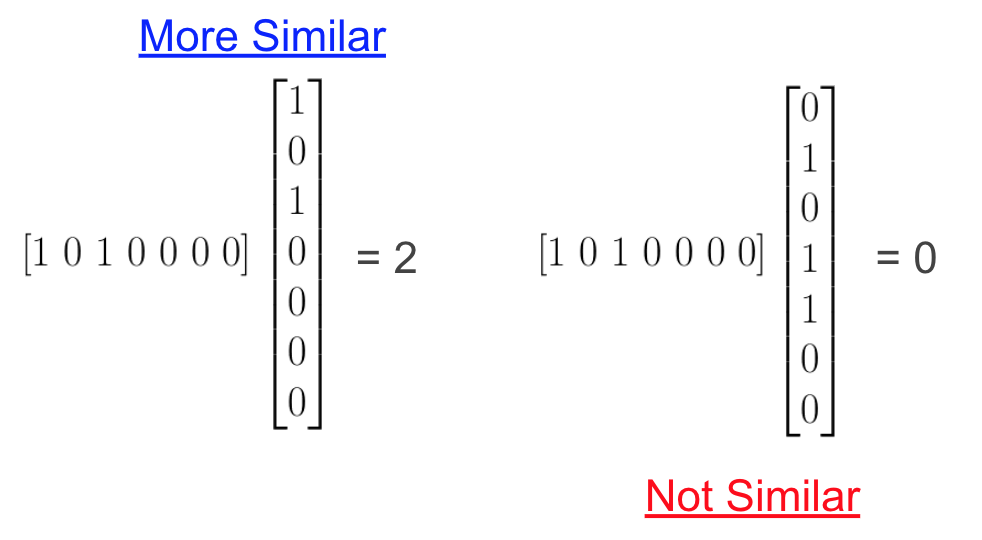



We can perform the dot product on a matrix of movies with content characteristics to provide a movie by movie matrix where each cell is an indication of how similar two movies are to one another.  In the below image, you can see that movies 1 and 8 are most similar, movies 2 and 8 are most similar, and movies 3 and 9 are most similar for this subset of the data.  The diagonal elements of the matrix will contain the similarity of a movie with itself, which will be the largest possible similarity (and will also be the number of 1's in the movie row within the orginal movie content matrix).

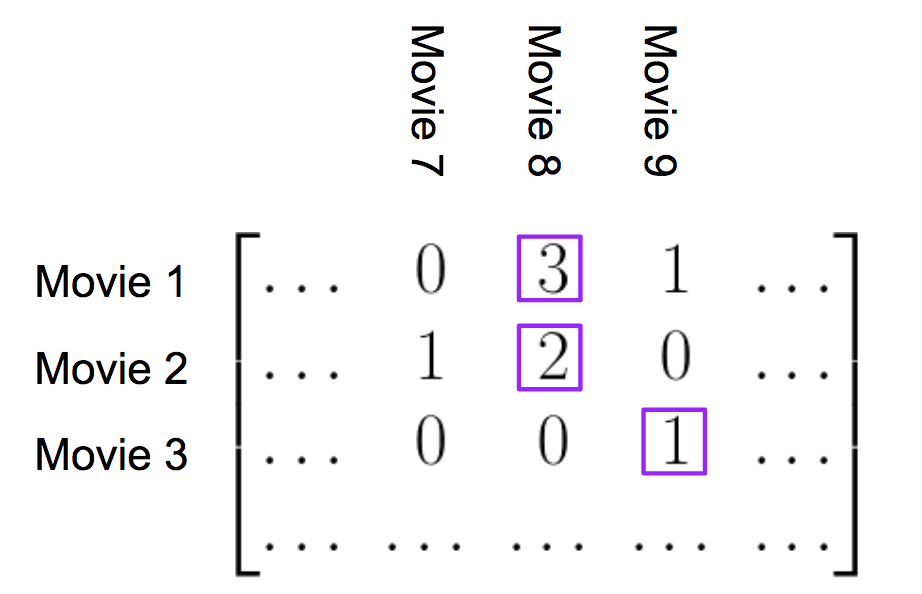

`3.` Create a numpy array that is a matrix of indicator variables related to year (by century) and movie genres by movie.  Perform the dot product of this matrix with itself (transposed) to obtain a similarity matrix of each movie with every other movie.  The final matrix should be 31245 x 31245.

In [71]:
movies.head()

,movie_id,movie,genre,date,1800's,1900's,2000's,History,News,Horror,...,Fantasy,Romance,Game-Show,Action,Documentary,Animation,Comedy,Short,Western,Thriller
0,8,Edison Kinetoscopic Record of a Sneeze (1894),Documentary|Short,1894,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,10,La sortie des usines Lumière (1895),Documentary|Short,1895,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,12,The Arrival of a Train (1896),Documentary|Short,1896,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,25,The Oxford and Cambridge University Boat Race ...,NaN,1895,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,91,Le manoir du diable (1896),Short|Horror,1896,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [33]:
movie_content = movies.set_index(['movie_id']).iloc[:,3:].values
movie_content

array([[1, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [36]:
# Subset so movie_content is only using the dummy variables for each genre and the 3 century based year dummy columns
movie_content = movies.set_index(['movie_id']).iloc[:,3:].values # use .values to convert a dataframe to a 2D array

# Take the dot product to obtain a movie x movie matrix of similarities
similarities = np.dot(movie_content, movie_content.transpose())
similarities


array([[3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 2, 2, 1],
       [0, 0, 0, ..., 2, 2, 1],
       [0, 0, 0, ..., 1, 1, 2]])

In [38]:
# create checks for the dot product matrix
assert similarities.shape[0] == 31245
assert similarities.shape[1] == 31245
assert similarities[0, 0] == np.max(similarities[0])
print("Looks like you passed all of the tests.  Though they weren't very robust - if you want to write some of your own, I won't complain!")

Looks like you passed all of the tests.  Though they weren't very robust - if you want to write some of your own, I won't complain!


### For Each User...


Now you have a matrix where each user has their ratings ordered.  You also have a second matrix where movies are each axis, and the matrix entries are larger where the two movies are more similar and smaller where the two movies are dissimilar.  This matrix is a measure of content similarity. Therefore, it is time to get to the fun part.

For each user, we will perform the following:

    i. For each movie, find the movies that are most similar that the user hasn't seen.

    ii. Continue through the available, rated movies until 10 recommendations or until there are no additional movies.

As a final note, you may need to adjust the criteria for 'most similar' to obtain 10 recommendations.  As a first pass, I used only movies with the highest possible similarity to one another as similar enough to add as a recommendation.

`3.` In the cell below, complete each of the functions needed for making content based recommendations.

In [84]:
movie_idx = np.where(movies.movie_id == 8)[0][0]
    
similar_idxs = np.where((similarities[movie_idx] ==  np.max(similarities[movie_idx])) & (similarities[movie_idx] != movie_idx))[0]
similar_idxs   
# pull the movie titles based on the indices
similar_movies = np.array(movies.loc[similar_idxs].movie)
similar_movies

array(['Edison Kinetoscopic Record of a Sneeze (1894)',
       'La sortie des usines Lumière (1895)',
       'The Arrival of a Train (1896)',
       'Annabelle Serpentine Dance (1895)',
       'Roundhay Garden Scene (1888)',
       'Llandudno Happy Valley and Minstrel Show (1898)'], dtype=object)

In [101]:
def find_similar_movies(movie_id):
    '''
    INPUT
    movie_id - a movie_id 
    OUTPUT
    similar_movies - an array of the most similar movies by title
    '''
    # find the row of each movie id
    movie_idx = np.where(movies.movie_id == movie_id)[0][0]
    
    # find the most similar movie indices - to start I said they need to be the same for all content
    similar_idxs = np.where((similarities[movie_idx] ==  np.max(similarities[movie_idx])) & (similarities[movie_idx] != movie_idx))
    
    # pull the movie titles based on the indices
    similar_movies = np.array(movies.loc[similar_idxs].movie)
    
    return similar_movies
    
# You made this function in an earlier notebook - using again here    
def get_movie_names(movie_ids):
    '''
    INPUT
    movie_ids - a list of movie_ids
    OUTPUT
    movies - a list of movie names associated with the movie_ids
    
    '''
    movie_lst = list(movies[movies['movie_id'].isin(movie_ids)]['movie'])
   
    return movie_lst

def make_recs():
    '''
    INPUT
    None
    OUTPUT
    recs - a dictionary with keys of the user and values of the recommendations
    '''
    # Create dictionary to return with users and ratings
    recs = defaultdict(set)
    
    # How many users for progress bar
    n_users = len(users_who_need_recs)
    
    # Create the progressbar
    cnter = 0
    bar = progressbar.ProgressBar(maxval = n_users+1, widgets = [progressbar.Bar('=','[',']'),'', progressbar.Percentage()])
    bar.start()   
    
    # For each user
    for user in users_who_need_recs:
        # Update the progress bar
        cnter += 1
        bar.update(cnter)

        # Pull only the reviews the user has seen
        reviews_temp = ranked_reviews[ranked_reviews['user_id'] == user]
        movies_temp = np.array(reviews_temp['movie_id'])
        movie_names = np.array(get_movie_names(movies_temp))
        
        # Look at each of the movies (highest ranked first), 
        # pull the movies the user hasn't seen that are most similar
        # These will be the recommendations - continue until 10 recs         
        # or you have depleted the movie list for the user
        for movie in movies_temp:
            rec_movies = find_similar_movies(movie)
            temp_recs = np.setdiff1d(rec_movies, movie_names)
            recs[user].update(temp_recs)
            
            # If there are more than 
            if len(recs[user]) > 9:
                break

    # finish the progress bar
    bar.finish()
    
    return recs

In [102]:
recs = make_recs()

[=========================================================================]100%


In [106]:
len(recs)

31781

### How Did We Do?

Now that you have made the recommendations, how did we do in providing everyone with a set of recommendations?

`4.` Use the cells below to see how many individuals you were able to make recommendations for, as well as explore characteristics about individuals for whom you were not able to make recommendations.  

In [104]:
# Some characteristics of my content based recommendations
users_without_all_recs = [] #store user ids without recs
users_with_all_recs = [] # users with all recs here
no_recs = [] # users with no recommendations

for i in recs.keys():
    if len(recs[i]) >= 10:
        users_with_all_recs.append(i)
    elif 0 < len(recs[i]) < 10:
        users_without_all_recs.append(i)
    elif len(recs[i]) == 0:
        no_recs.append(i)

In [105]:

print("There were {} users without all 10 recommendations we would have liked to have.".format(len(users_without_all_recs)))
print("There were {} users with all 10 recommendations we would like them to have.".format(len(users_with_all_recs)))
print("There were {} users with no recommendations at all!".format(len(no_recs)))

There were 2004 users without all 10 recommendations we would have liked to have.
There were 29603 users with all 10 recommendations we would like them to have.
There were 174 users with no recommendations at all!


In [108]:
reviews[reviews['user_id'].isin(no_recs)]

,user_id,movie_id,rating,timestamp,date,month_1,month_2,month_3,month_4,month_5,...,month_9,month_10,month_11,month_12,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
2827,189,457430,5,1449982902,2015-12-13 05:01:42,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
9138,797,4215352,8,1431996724,2015-05-19 00:52:04,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
17133,1603,2771200,10,1490557295,2017-03-26 19:41:35,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
21722,2056,1895315,9,1476468308,2016-10-14 18:05:08,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
26042,2438,3890160,9,1501793296,2017-08-03 20:48:16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692588,52590,120794,5,1450822646,2015-12-22 22:17:26,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
696291,52838,3890160,8,1505366371,2017-09-14 05:19:31,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
696933,52901,2005374,8,1377407141,2013-08-25 05:05:41,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
703375,53243,2180411,1,1419833653,2014-12-29 06:14:13,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [94]:
# Closer look at individual user characteristics - this may help it was from an earlier notebook
user_items = reviews[['user_id', 'movie_id', 'rating']]
user_by_movie = user_items.groupby(['user_id', 'movie_id'])['rating'].max().unstack()

def movies_watched(user_id):
    '''
    INPUT:
    user_id - the user_id of an individual as int
    OUTPUT:
    movies - an array of movies the user has watched
    '''
    movies = user_by_movie.loc[user_id][user_by_movie.loc[user_id].isnull() == False].index.values

    return movies


movies_watched(189)

array([457430])

Viewers who only have one review can not get a content recommendation.

### Now What?  

Well, if you were really strict with your criteria for how similar two movies are (like I was initially), then you still have some users that don't have all 10 recommendations (and a small group of users who have no recommendations at all). 

As stated earlier, recommendation engines are a bit of an **art** and a **science**.  There are a number of things we still could look into - how do our collaborative filtering and content based recommendations compare to one another? How could we incorporate user input along with collaborative filtering and/or content based recommendations to improve any of our recommendations?  How can we truly gain recommendations for every user?

`5.` In this last step feel free to explore any last ideas you have with the recommendation techniques we have looked at so far.  You might choose to make the final needed recommendations using the first technique with just top ranked movies.  You might also loosen up the strictness in the similarity needed between movies.  Be creative and share your insights with your classmates!

## Three Types of Recommendations
There are three methods that you have now implemented for making recommendations. These are the three most recognized methods in industry:

1. Knowledge Based Recommendations

Knowledge based recommendations frequently are implemented using filters, and are extremely common amongst luxury based goods. Filters that you might see when purchasing items like cars or homes are examples of knowledge based recommendations. In knowledge based recommendations, users provide information about the types of recommendations they would like back.

2. Collaborative Filtering Based Recommendations

Collaborative filtering uses the connections between users and items to make recommendations. Even the content based recommendation you just implemented used some collaborative filtering techniques, as you were not treating items and users independent from one another. In this lesson, you used neighborhood based collaborative filtering to find users who were alike and then recommend new movies based on these similar users.

Even in the content based recommendation, you were using collaborative filtering. You were finding items that were similar and making recommendations of new items based on the highest ratings of a user. Because you were still using the user ratings of an item, this was an example of a blend between content and collaborative filtering based techniques.

3. Content Based Recommendations

In the previous notebook, you created a matrix of similarities between items (movies) based only on the content related to those movies (year and genre). The similarity matrix that was used, was completely created using only the items (movies). There was no information used about the users implemented. For any movie, you would be able to determine the most related additional movies based only on the genre and the year of the movie. This is the premise of how a completely content based recommendation would be made.

Often blended techniques of all three types are used in practice to provide the the best recommendation for a particular circumstance.

There are still more advanced techniques that are related to the methods that you learned about here, and they will most likely fall in one of the three buckets below.

- [AirBnB uses embeddings in their recommendation, which you can read more about here.](https://medium.com/airbnb-engineering/listing-embeddings-for-similar-listing-recommendations-and-real-time-personalization-in-search-601172f7603e)
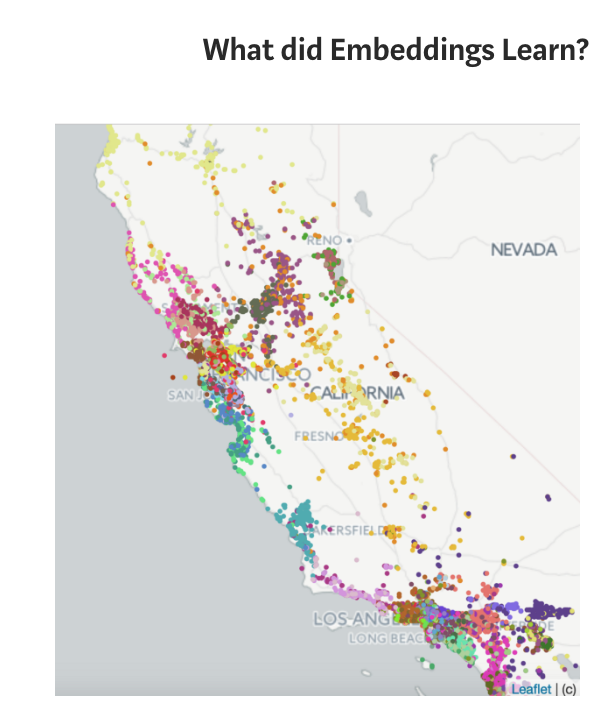

- [As our smart phones become more addicting every day, it is easy to see why location based recommendations will be more and more popular. You can read more about these types of recommendations here.](https://link.springer.com/referenceworkentry/10.1007%2F978-3-319-17885-1_1580)
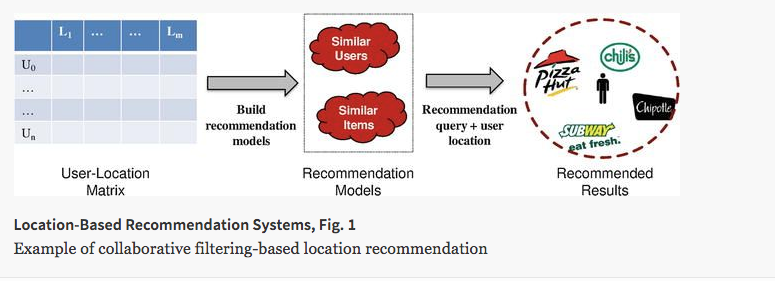

- [Many companies are also exploring deep learning use cases in recommendation systems.](https://ebaytech.berlin/deep-learning-for-recommender-systems-48c786a20e1a)
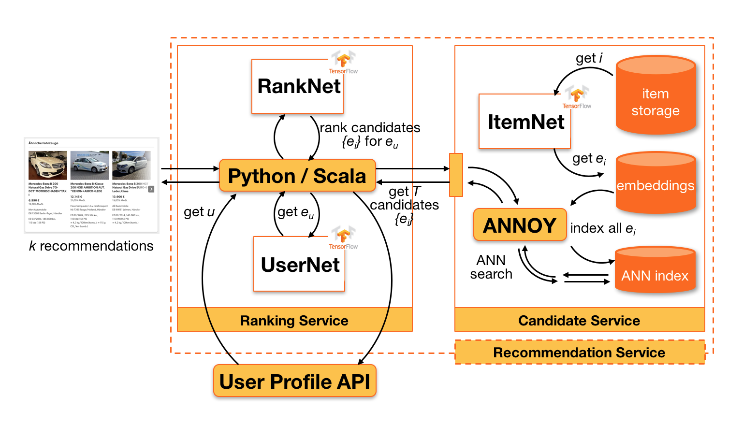

## Different Scales
If you are in control of choosing your rating scale, think of what might be most beneficial to your scenario. If you are working alongside a team TO design the interfaces for how data will be collected, there are number of ideas to keep in mind.

- Do you need to ask questions of your user or can you collect data about their interactions with items?
- If you need to ask questions, how many do you ask?
- How do you word the questions?
- And finally, the question in the above video: what type of scale should you use?

In general, I suggest using the simplest rating that allows you to get whatever questions of interest you have, but there are some important ideas to keep in mind when choosing a particular type of rating. Ratings are a necessary part of working with different recommendation systems, but they aren't a central part of our focus. A good overview of types of ratings and when to use them is also provided [here](https://conversionxl.com/blog/survey-response-scales/).

Most of these ideas are specific to your use case, and are easy to notice in hindsight. It is simply important to think of this in advance and not completely gloss over possible issues with the data you are collecting and how it connects to the questions you want answered.

## Business Goals of Recommendations
In general, recommendations are important because they are often central to driving revenue for a company. In the new world of the Internet, you don't always need a friend to personally recommend you an item you never heard of - instead, the recommendations can do this.

There are ultimately 4 goals to keep in mind when performing recommendations:

1. Relevance
2. Novelty (Novelty determines how unknown recommended items are to a user)
3. Serendipity (Among all of the metrics I will discuss in this post, serendipity is my favorite. It is the measure of how surprising the successful or relevant recommendations are )
4. Diversity

Often people only think of the first goal, and it is a good reminder that focusing only on **relevance** can lead to drops in use, and therefore loss of revenue. We also need to consider the other three goals, so that recommendations can be most effective in driving sales. In this article, [Lab41 shows how they worked to quantify these metrics.](https://gab41.lab41.org/recommender-systems-its-not-all-about-the-accuracy-562c7dceeaff)

## Recap
### Types of Recommendations
In this lesson, you worked with the MovieTweetings data to apply each of the three methods of recommendations:

1. Knowledge Based Recommendations
2. Collaborative Filtering Based Recommendations
3. Content Based Recommendations

Within Collaborative Filtering, there are two main branches:

1. Model Based Collaborative Filtering
2. Neighborhood Based Collaborative Filtering

In this lesson, you implemented Neighborhood Based Collaborative Filtering. In the next lesson, you will implement Model Based Collaborative Filtering.

### Similarity Metrics
In order to implement Neighborhood Based Collaborative Filtering, you were introduced to and applied a few techniques to assess how similar or distant two users were from one another:

1. Pearson's correlation coefficient
2. Spearman's correlation coefficient
3. Kendall's Tau
4. Euclidean Distance
5. Manhattan Distance

### Types of Ratings
We took a quick look at different types of ratings:

1. Did the user interact with an item or not.
2. Did the user like an item or not.
3. More granular scales 1-7, 1-10, etc.

It is important to understand what the data might be used for, and what type of granularity might be important for a particular case. One of the main considerations is whether you want to have neutrality available, in which case an odd number of possible values in your scale will provide a value in the middle. Another common question is, how many levels do you really need to understand how much a user likes a particular product? Again, this is largely up to individual preference and specific use cases.

### Business Cases For Recommendations
Finally, you looked at the four ideas needed for businesses to implement successful recommendations to drive revenue, which include:

1. Relevance
2. Novelty
3. Serendipity
4. Increased Diversity
At the end of this lesson, you will have gained a ton of skills to build upon or to start creating your own recommendations in practice.